# Imagenet comparison

Note that here we overwrite the config samples sizes to reduced the run time 

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load configs

In [8]:
import datetime
import os
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
from torch.distributions import MultivariateNormal

from labproject.data import DATASETS, DISTRIBUTIONS, get_dataset
from labproject.experiments import *
from labproject.plotting import cm2inch, generate_palette
from labproject.utils import get_cfg, get_cfg_from_file, get_log_path, set_seed

# inline plotting
%matplotlib inline



print("Running experiments...")
# load the config file
cfg = get_cfg_from_file("conf_embedding_samplesize")
cfg.running_user = 'embedding_samplesize'
seed = cfg.seed

set_seed(seed)
print(f"Seed: {seed}")
print(f"Experiments: {cfg.experiments}") 
print(f"Data: {cfg.data}")

# assert cfg.data is list
assert len(cfg.data) == len(cfg.n) == len(cfg.d), "Data, n and d must be lists of the same length"
    
# setup colors and labels for plotting

color_dict = {"wasserstein": "#cc241d",
              "mmd": "#eebd35",
              "c2st": "#458588",
              "fid": "#8ec07c", 
              "kl": "#8ec07c"}


col_map = {'ScaleSampleSizeKL':'kl', 'ScaleSampleSizeSW':'wasserstein',
           'ScaleSampleSizeMMD':'mmd', 'ScaleSampleSizeC2ST':'c2st',
           'ScaleSampleSizeFID':'fid', 'ScaleDimKL':'kl', 'ScaleDimSW':'wasserstein',
           'ScaleDimMMD':'mmd', 'ScaleDimC2ST':'c2st', 'ScaleGammaMMD':'mmd',
           'ScaleDimFID':'fid',}

mapping = {'ScaleSampleSizeKL':'KL', 'ScaleSampleSizeSW':'SW',
           'ScaleSampleSizeMMD':'MMD', 'ScaleSampleSizeC2ST':'C2ST',
           'ScaleSampleSizeFID':'FD', 'ScaleDimKL':'KL', 'ScaleDimSW':'SW',
           'ScaleDimMMD':'MMD', 'ScaleDimC2ST':'C2ST',
           'ScaleDimFID':'FD', 'ScaleGammaMMD':'MMD'}

# dark and light colors for inter vs. intra comparisons 
col_dark = {}
col_light = {}
for e, exp_name in enumerate(cfg.experiments):
    col_dark[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='dark')[2]
    col_light[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='light')[-1]
    
color_list = [col_light, col_dark] # make this a list to account for true and shifted

label_true = {}
label_shift = {}
for e, data_name in enumerate(cfg.data):
    label_true[data_name] = "true"
    label_shift[data_name] = "generated"
    
label_list = [label_true, label_shift]
label_list[1]['toy_2d'] = 'approx.'
label_list[1]['random'] = 'shifted'


Running experiments...
Seed: 0
Experiments: ['ScaleSampleSizeSW', 'ScaleSampleSizeC2ST', 'ScaleSampleSizeMMD', 'ScaleSampleSizeFID']
Data: ['imagenet_real_embeddings']


## Run over the embedding nets and compute all metrics for uncoditional samples and the imagenet image embeddings

imagenet_real_embeddings 10000 2048
Experiment ScaleSampleSizeSW finished in 0.02710127830505371
Numerical results saved to results/embedding_samplesize/embeddings_samplesize_SW_imagenet_real_embeddings_0_.pkl
Experiment ScaleSampleSizeSW finished in 0.030950546264648438
Numerical results saved to results/embedding_samplesize/embeddings_samplesize_SW_imagenet_real_embeddings_1_.pkl
Experiment ScaleSampleSizeC2ST finished in 20.54231882095337
Numerical results saved to results/embedding_samplesize/embeddings_samplesize_C2ST_imagenet_real_embeddings_0_.pkl
Experiment ScaleSampleSizeC2ST finished in 17.359854698181152
Numerical results saved to results/embedding_samplesize/embeddings_samplesize_C2ST_imagenet_real_embeddings_1_.pkl
MMD
Experiment ScaleSampleSizeMMD finished in 0.09720230102539062
Numerical results saved to results/embedding_samplesize/embeddings_samplesize_MMD_imagenet_real_embeddings_0_.pkl
MMD
Experiment ScaleSampleSizeMMD finished in 0.030948638916015625
Numerical resul

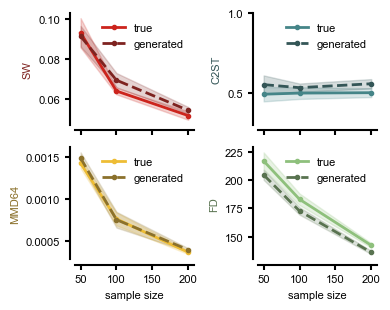

In [10]:
# make comparison plots
fig, axes = plt.subplots(2, 2, figsize=cm2inch((10, 8)), sharex="col")
for ax in axes.flatten():
    # move spines outward
    ax.spines["bottom"].set_position(("outward", 4))
    ax.spines["left"].set_position(("outward", 4))
    ax.locator_params(nbins=4)

sample_sizes = cfg.sample_sizes

# COMMENT OUT THE FOLLOWING LINES TO RUN THE ACTUAL EXPERIMENTS
sample_sizes = [50,100,200,] # reduced experiment

for dd, ds in enumerate(cfg.data):
    dataset_fn = get_dataset(cfg.data[dd])
    n_samples = cfg.n[dd]

    dataset_gt = dataset_fn(n_samples, cfg.d[dd])
    dataset_intra = dataset_fn(n_samples, cfg.d[dd])

    print(cfg.data[dd], n_samples, cfg.d[dd])

    assert (
        cfg.data[dd] == "imagenet_real_embeddings"
    ), "Only embeddings are supported for this experiment"
    dataset_fn = get_dataset(cfg.augmentation[dd])
    dataset_inter = dataset_fn(n_samples, cfg.d[dd])

    for e, exp_name in enumerate(cfg.experiments):
        experiment = globals()[exp_name]()
        ax = axes.flatten()[e]
        for dc, data_comp in enumerate([dataset_intra, dataset_inter]):
            assert (
                dataset_gt.shape == data_comp.shape
            ), f"Dataset shapes do not match: {dataset_gt.shape} vs. {data_comp.shape}"

            time_start = time.time()
            if mapping[exp_name] == "MMD":
                print("MMD")
                output = experiment.run_experiment(
                    dataset1=dataset_gt,
                    dataset2=data_comp,
                    sample_sizes=sample_sizes,
                    nb_runs=cfg.runs,
                    bandwidth=cfg.bandwidth,
                )
            else:
                output = experiment.run_experiment(
                    dataset1=dataset_gt,
                    dataset2=data_comp,
                    sample_sizes=sample_sizes,
                    nb_runs=cfg.runs,
                )
            time_end = time.time()
            print(f"Experiment {exp_name} finished in {time_end - time_start}")

            # log results
            log_path = get_log_path(
                cfg, tag=f"_{mapping[exp_name]}_{cfg.data[dd]}_{dc}", timestamp=False
            )
            os.makedirs(os.path.dirname(log_path), exist_ok=True)
            experiment.log_results(output, log_path)
            print(f"Numerical results saved to {log_path}")

            # plot results
            experiment.plot_experiment(
                *output,
                cfg.data[dd],
                ax=ax,
                color=color_list[dc][exp_name],
                label=label_list[dc][cfg.data[dd]],
                linestyle="-" if dc == 0 else "--",
                lw=2,
                marker="o",
            )

            ax.set_ylabel(
                mapping[exp_name] + str(cfg.bandwidth)
                if mapping[exp_name] == "MMD"
                else mapping[exp_name]
            )
            ax.set_xlabel("")

            if mapping[exp_name] == "C2ST":
                ax.set_ylim([0.30, 1])
                ax.set_yticks([0.5, 1])

        ax.legend()

axes[-1, 0].set_xlabel("sample size")
axes[-1, 1].set_xlabel("sample size")
os.makedirs("./results/plots", exist_ok=True)

fig.tight_layout()
fig.savefig(
    f"./results/plots/{cfg.exp_log_name}_metric_comparison_sample_size_{cfg.data}_only_embed_MMD_{cfg.bandwidth}.png",
    dpi=300,
)
fig.savefig(
    f"./results/plots/{cfg.exp_log_name}_metric_comparison_sample_size_{cfg.data}_only_embed_MMD_{cfg.bandwidth}.pdf",
    dpi=300,
)

print("Finished running experiments.")